# Neutronics CALPHAD Example Usage

This notebook demonstrates how to use the `neutronics_calphad` package for tokamak neutronics simulations and alloy optimization.


## Setup

First, import the package and check that everything is working:


In [1]:
import neutronics_calphad as nc
import numpy as np
import matplotlib.pyplot as plt

print(f"Package version: {nc.__version__}")
print(f"Available elements: {nc.ELMS}")


n-001_H_002.endf: Warning, LTT (3) for elastic scattering, using Legendre only
n-006_C_012.endf: Warning, LTT (3) for elastic scattering, using Legendre only


/home/myless/.miniforge3/envs/neutronics_calphad/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Package version: 0.1.0


AttributeError: module 'neutronics_calphad' has no attribute 'ELMS'

## 1. Create and Visualize Tokamak Geometry

Let's create a tokamak model with a vanadium vacuum vessel:


In [ ]:
# Create a model with vanadium vacuum vessel
model = nc.create_model('V')

print("Model created successfully!")
print(f"Number of materials: {len(model.materials)}")
print(f"Number of cells: {len(model.geometry.get_all_cells())}")


# Testbed for run_script

## Define libraries

In [1]:
from neutronics_calphad.neutronics.config import SPHERICAL
from neutronics_calphad.neutronics.geometry_maker import create_model
import openmc
import openmc.deplete
import os

openmc.config['chain_file'] = '/home/myless/nuclear_data/tendl21-fispact20-gefy61-chain.xml'
openmc.config['cross_sections'] = '/home/myless/nuclear_data/tendl-2021-hdf5/cross_sections.xml'

chain = openmc.deplete.Chain.from_xml(openmc.config['chain_file'])

print(dir(chain))
print(chain.reactions)



# 1) Create a spherical geometry using the config file 
model = create_model(config=SPHERICAL)
model.settings.particles = 100

n-001_H_002.endf: Warning, LTT (3) for elastic scattering, using Legendre only
n-006_C_012.endf: Warning, LTT (3) for elastic scattering, using Legendre only


/home/myless/.miniforge3/envs/neutronics_calphad/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_fission_yields', '_follow', '_xml_path', 'add_nuclide', 'export_to_xml', 'fission_yields', 'form_ext_source_term', 'form_matrix', 'form_rr_term', 'from_endf', 'from_xml', 'get_branch_ratios', 'get_default_fission_yields', 'nuclide_dict', 'nuclides', 'reactions', 'reduce', 'set_branch_ratios', 'stable_nuclides', 'unstable_nuclides', 'validate']
['(n,gamma)', '(n,2n)', '(n,p)', '(n,d)', '(n,t)', '(n,a)', '(n,3n)', '(n,4n)', 'fission']


Right now the chain only supports:
['(n,gamma)', '(n,2n)', '(n,p)', '(n,d)', '(n,t)', '(n,a)', '(n,3n)', '(n,4n)', 'fission']

But we need:

The default chain you have only does 7 reactions: (n,gamma), (n,2n), (n,p), (n,alpha), (n,3n), (n,4n), (n,fission) since it was designed for reactor physics. Just looking at the other reactions in the fispact collapse output we have things like (n,d), (n,t), (n,na), (n,2na), (n,3na), (n,t2a), and probably a few other crazy ones as well. 

I need:
(n,na), (n,2na), (n,3na), and (n,t2a)

In [2]:
all_cells = model.geometry.get_all_cells()
cells_list = list(all_cells.values())
print(cells_list)

[Cell
	ID             =	1
	Name           =	core
	Fill           =	None
	Region         =	-1
	Rotation       =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	2
	Name           =	first_wall
	Fill           =	Material 1
	Region         =	(-2 1)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	3
	Name           =	vessel
	Fill           =	Material 3
	Region         =	(-3 2)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	4
	Name           =	blanket
	Fill           =	Material 2
	Region         =	(-4 3)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	5
	Name           =	tank
	Fill           =	Material 4
	Region         =	(-5 4)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	6
	Name           

### Specify Tallies for Gas Production

In [3]:
cell_filter = openmc.CellFilter(model.geometry.get_cells_by_name('vessel')[0])
h1_tally = openmc.Tally(name='H1')
h1_tally.filters = [cell_filter]
h1_tally.scores = ['H1-production']



### Run Get MicroXS and FLux

In [4]:
# 2) run get_microxs_and_flux to get the microxs and flux
flux, microxs = openmc.deplete.get_microxs_and_flux(model,
                                                    cells_list,
                                                    energies='UKAEA-1102',
                                                    chain_file=openmc.config['chain_file'],
                                                    run_kwargs={'cwd': 'microxs_and_flux'},
                                                    path_statepoint=os.path.join('microxs_and_flux', 'microxs_statepoint.10.h5'))

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

KeyboardInterrupt: 

## 3 Replace the material at the vv with a candidate material

In [ ]:
# create a new material or list of materials 

from typing import Dict

def material_string(comp_dict: Dict[str, float], bal_element: str) -> str:
    """Generate a material string of the form 'bal_element-2Cr-4Ti-3W-1Zr'.

    Args:
        comp_dict (Dict[str, float]): Dictionary of element fractions.
        bal_element (str): The balance element to use as prefix.

    Returns:
        str: Formatted material string.
    """
    parts = []
    for element, value in comp_dict.items():
        if element != bal_element:
            parts.append(f"{int(round(value * 100))}{element}")
    return f"{bal_element}-" + "-".join(parts)

test_material = {
    'V': 0.9,
    'Cr': 0.02,
    'Ti': 0.04,
    'W': 0.03,
    'Zr': 0.01
}

material_name = material_string(test_material, 'V')
print(material_name)  # Output: V-2Cr-4Ti-3W-1Zr


def create_material(comp_dict, material_name, bal_element = 'V', density = 6.11, percent_type = 'ao'):
    new_material = openmc.Material()
    new_material.set_density('g/cm3', density)
    for element, percent in comp_dict.items():
        new_material.add_element(element, percent, percent_type)
    new_material.name = material_name
    
    return new_material

new_material = create_material(test_material, material_name)
print(new_material)


V-2Cr-4Ti-3W-1Zr


NameError: name 'openmc' is not defined

In [ ]:
# make new material depletable 
new_material.depletable = True

# add to materials
model.materials.append(new_material)

In [ ]:
model.geometry.get_all_material_cells()

{2: Cell
 	ID             =	2
 	Name           =	first_wall
 	Fill           =	Material 1
 	Region         =	(-2 1)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 3: Cell
 	ID             =	3
 	Name           =	vessel
 	Fill           =	Material 3
 	Region         =	(-3 2)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 4: Cell
 	ID             =	4
 	Name           =	blanket
 	Fill           =	Material 2
 	Region         =	(-4 3)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 5: Cell
 	ID             =	5
 	Name           =	tank
 	Fill           =	Material 4
 	Region         =	(-5 4)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 6: Cell
 	ID             =	6
 	Name           =	shield
 	Fill           =	Material 5
 	Region         =	(-6 5)
 	Rotation       =	None
 	Temperature    =	None
 

In [ ]:
cell_name = 'vessel'
vv_cell = model.geometry.get_cells_by_name(cell_name)
for mat in model.materials:
    if mat.name == 'vcrtiwzr':
        new_volume = mat.volume
new_material.volume = new_volume
vv_cell[0].fill = new_material
print(vv_cell[0].fill)

Material
	ID             =	6
	Name           =	V-2Cr-4Ti-3W-1Zr
	Temperature    =	None
	Density        =	6.11 [g/cm3]
	Volume         =	327780.54089851223 [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	V50            =	0.0022500000000000003 [ao]
	V51            =	0.89775      [ao]
	Cr50           =	0.0008690000000000001 [ao]
	Cr52           =	0.0167578    [ao]
	Cr53           =	0.0019002    [ao]
	Cr54           =	0.000473     [ao]
	Ti46           =	0.0033000000000000004 [ao]
	Ti47           =	0.002976     [ao]
	Ti48           =	0.029488     [ao]
	Ti49           =	0.002164     [ao]
	Ti50           =	0.002072     [ao]
	W180           =	3.5999999999999994e-05 [ao]
	W182           =	0.00795      [ao]
	W183           =	0.004293     [ao]
	W184           =	0.009192     [ao]
	W186           =	0.008529     [ao]
	Zr90           =	0.005144999999999999 [ao]
	Zr91           =	0.001122     [ao]
	Zr92           =	0.0017150000000000002 [ao]
	Zr94           =	0.0017380000000000002 [ao

In [ ]:
# To get the first value in a dictionary (e.g., an OpenMC material object), use next(iter(dict.values()))
first_material = next(iter(vv_cell[0].get_all_materials().values()))
print("First material object:", first_material)

First material object: Material
	ID             =	6
	Name           =	V-2Cr-4Ti-3W-1Zr
	Temperature    =	None
	Density        =	6.11 [g/cm3]
	Volume         =	327780.54089851223 [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	V50            =	0.0022500000000000003 [ao]
	V51            =	0.89775      [ao]
	Cr50           =	0.0008690000000000001 [ao]
	Cr52           =	0.0167578    [ao]
	Cr53           =	0.0019002    [ao]
	Cr54           =	0.000473     [ao]
	Ti46           =	0.0033000000000000004 [ao]
	Ti47           =	0.002976     [ao]
	Ti48           =	0.029488     [ao]
	Ti49           =	0.002164     [ao]
	Ti50           =	0.002072     [ao]
	W180           =	3.5999999999999994e-05 [ao]
	W182           =	0.00795      [ao]
	W183           =	0.004293     [ao]
	W184           =	0.009192     [ao]
	W186           =	0.008529     [ao]
	Zr90           =	0.005144999999999999 [ao]
	Zr91           =	0.001122     [ao]
	Zr92           =	0.0017150000000000002 [ao]
	Zr94           =	0.

## RUn the depletion with independent operator

In [ ]:
# calculate the source_rate 
POWER_MW = 500
FUSION_POWER_MEV = 17.6
MEV_TO_J = 1.602176634e-13
SOURCE_RATE = POWER_MW * 1E6 / (FUSION_POWER_MEV * MEV_TO_J)
print(SOURCE_RATE)

1.7731559870627162e+20


In [ ]:
from neutronics_calphad.neutronics.time_scheduler import TimeScheduler
from neutronics_calphad.neutronics.depletion import run_independent_depletion

cooling_times = ['2 weeks', '1 year', '10 years', '100 years']
# create the time scheduler 
time_scheduler = TimeScheduler(irradiation_time='1 year',
                               cooling_times=cooling_times,
                               source_rate=SOURCE_RATE,
                               irradiation_steps=12)


print(time_scheduler.get_timesteps_and_source_rates())

([2629800.0, 2629800.0, 2629800.0, 2629800.0, 2629800.0, 2629800.0, 2629800.0, 2629800.0, 2629800.0, 2629800.0, 2629800.0, 2629800.0, 1209600.0, 30348000.0, 284018400.0, 2840184000.0], [1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 1.7731559870627162e+20, 0.0, 0.0, 0.0, 0.0])


In [ ]:
import os
cell_name = 'vessel'
# get the index of the domain where the cell is cell_name
model.geometry.get_all_cells()


{1: Cell
 	ID             =	1
 	Name           =	core
 	Fill           =	None
 	Region         =	-1
 	Rotation       =	None
 	Translation    =	None
 	Volume         =	None,
 2: Cell
 	ID             =	2
 	Name           =	first_wall
 	Fill           =	Material 1
 	Region         =	(-2 1)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 3: Cell
 	ID             =	3
 	Name           =	vessel
 	Fill           =	Material 6
 	Region         =	(-3 2)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 4: Cell
 	ID             =	4
 	Name           =	blanket
 	Fill           =	Material 2
 	Region         =	(-4 3)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 5: Cell
 	ID             =	5
 	Name           =	tank
 	Fill           =	Material 4
 	Region         =	(-5 4)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume     

In [ ]:
print(len(flux))
# find the index of the cell in all_cells_list that has a name of 'vessel'
vessel_cell_index = next(index for index, cell in enumerate(cells_list) if cell.name == 'vessel')
print(vessel_cell_index)

# get the flux for the vessel cell
vessel_flux = flux[vessel_cell_index]
print(vessel_flux)

print(len(microxs))
print(microxs[vessel_cell_index])

7
2
[0. 0. 0. ... 0. 0. 0.]
7


In [ ]:

results = run_independent_depletion(
    model=model,
    depletable_cell=cell_name,
    microxs=microxs[vessel_cell_index],
    flux=flux[vessel_cell_index],
    chain_file=openmc.config['chain_file'],
    timesteps=time_scheduler.get_timesteps_and_source_rates()[0],
    source_rates=time_scheduler.get_timesteps_and_source_rates()[1],
    outdir=os.path.join('depletion_results', material_name)
)

Using material for depletion: V-2Cr-4Ti-3W-1Zr
Running depletion with enhanced numerical stability settings...
[openmc.deplete] t=0.0 s, dt=2629800.0 s, source=1.7731559870627162e+20


[openmc.deplete] t=2629800.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=5259600.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=7889400.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=10519200.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=13149000.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=15778800.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=18408600.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=21038400.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=23668200.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=26298000.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=28927800.0 s, dt=2629800.0 s, source=1.7731559870627162e+20
[openmc.deplete] t=31557600.0 s, dt=1209600.0 s, source=0.0


/home/myless/.miniforge3/envs/neutronics_calphad/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


[openmc.deplete] t=32767200.0 s, dt=30348000.0 s, source=0.0
[openmc.deplete] t=63115200.0 s, dt=284018400.0 s, source=0.0
[openmc.deplete] t=347133600.0 s, dt=2840184000.0 s, source=0.0
[openmc.deplete] t=3187317600.0 (final operator evaluation)


# calculating contact dose

In [2]:
import openmc
import openmc.deplete
import os 
# check if the results variable exists 
# if it does not, read the results from the file


#results_path = os.path.join('depletion_results', material_name, 'depletion_results.h5')
results_path = '/home/myless/Packages/neutronics_calphad/examples/depletion_results/V-2Cr-4Ti-3W-1Zr/depletion_results.h5'
if 'results' not in locals() or results is None:
    if os.path.exists(results_path):
        results = openmc.deplete.Results(results_path)
    else:
        raise FileNotFoundError(f"Depletion results file not found at {results_path}")

In [ ]:
# calculate the dose rate at the specific time steps for that material 
from neutronics_calphad.neutronics.dose import contact_dose
from neutronics_calphad.neutronics.depletion import extract_gas_production






dose_rates = contact_dose(
    results=results,
    chain_file=openmc.config['chain_file'],
    abs_file='/home/myless/Packages/fispact/nuclear_data/decay/abs_2012'
)

print(dose_rates)

n-001_H_002.endf: Warning, LTT (3) for elastic scattering, using Legendre only
n-006_C_012.endf: Warning, LTT (3) for elastic scattering, using Legendre only


/home/myless/.miniforge3/envs/neutronics_calphad/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'new_material' is not defined

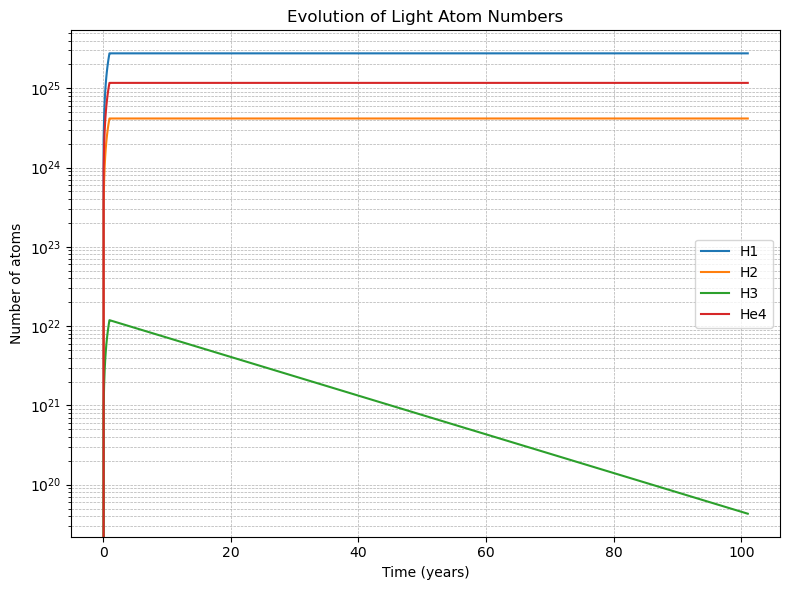

In [ ]:
import matplotlib.pyplot as plt
from typing import List, Tuple

def plot_light_atom_numbers(
    results: "openmc.deplete.Results",
    material: "openmc.Material",
    atom_types: List[str]
) -> None:
    """
    Plot the number of atoms for each specified light atom on a log scale
    for all time steps.

    Args:
        results: The OpenMC depletion results object.
        material: The material for which to extract atom numbers.
        atom_types: List of nuclide names (e.g., ['H1', 'H2', 'H3', 'He4']).
    """
    plt.figure(figsize=(8, 6))
    for atom in atom_types:
        times, numbers = results.get_atoms(material, atom)
        plt.plot(times / (3600 * 24 * 365.25), numbers, label=atom)  # Convert seconds to years

    plt.yscale('log')
    plt.xlabel('Time (years)')
    plt.ylabel('Number of atoms')
    plt.title('Evolution of Light Atom Numbers')
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()

light_atoms = ['H1', 'H2', 'H3', 'He4']
plot_light_atom_numbers(results, new_material, light_atoms)

In [ ]:
from neutronics_calphad.optimizer.evaluate_updated import evaluate_material

evaluate_material(results)

FileNotFoundError: [Errno 2] No such file or directory: 'critical.json'